<div class="alert alert-success">
    <h1 align='center'><font face="Trebuchet MS">Capstone Project - Capstone Project - Toronto Restaurant Map</font></h1>
    <br>
</div>

<div class='alert alert-info'>
    <h3 align='center'><font face="Trebuchet MS">INTRODUCTION / BUSINESS PROBLEM</font></h3><br>
    <hr><font face="Trebuchet MS">
    The continent of North America has a long history of immigration dated back to several centuries. As the general public describes, it is truly a "melting pot"  both culture-wise and dinning-wise. As one of the biggest cities of Canada, Toronto has a considerable diverse population in terms of ethnics settling in its lively boroughs and neighborhoods. Meanwhile, attracted by the aesthetic and gourmet characteristics of the city, as well as the free, open and welcoming culture it had, Toronto accommodates millions of tourists from all over the world.
    <br>
    <h4>Hypothetical Scenario</h4>
    Commissioned by a US-based investor who's investing and culturing a few start-up restaurants in Toronto, our objective is to assist the restaurants' operation staff in getting acquainted with the city and setting up standards for assessing and evaluating the restaurants business conditions. 
    <br>
    <h4>Playback</h4>
    During the initiating stage we have scrapped Toronto's neighbourhood and postal code data from Wikipedia, searched and matched the geographical coordinates against each Postal Code, utilized Foursquares APIs to examine venues around, and eventually segmented and clustered these neighbourhoods by their unique venue composition in the number of the investor's intended number of restaurants to be opened (<i>reference to "Segmenting and Clustering Neighbourhoods in Toronto 3: Map clustering" notebook</i>). Based upon the information we provided, the stakeholders now have a clearer expectation on how should the intended restaurants should be positioned in each of the fitting clusters.
    <br>
    <h4>Objective</h4>
    Now that since all the stakeholders have a concept of how the restaurants shall be distributed in the clustered neighbourhoods, and their respective surrounding municipal context, the next step is to further explore venues around them to grasp information on:
    <ol><i>
        <li>Major cuisines in dining themed clusters as suggestions to our restaurants' cuisine selection;</li>
        <li>Ratings of the restaurants in dining themed clusters and how they are distributed. Thus we could set a rating target for our restaurants sitting in the context;</li>
        <li>Naming suggestions for the restaurants in the clusters with theme other than dining, referencing to their overall venue names.</li>
        </i></ol>
    Based upon these information our restaurants could then set up and get running.
    </font><hr>
</div>

<div class='alert alert-info'>
    <h3 align='center'><font face="Trebuchet MS">DATA</font></h3><br>
    <hr>
    <font face="Trebuchet MS">
        <h4>Base Data</h4>
        The data to be used as foundation for this research will be the output from last stage, "Segmenting and Clustering Neighbouthoods in Toronto", which is a CSV file containing neighbourhood Postal Codes, boroughs, geographical coordinates, venues of interest and cluster IDs.
        <br>
        The source data is scrapped from <a ref='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'>Wikipedia: List of postal codes of Canada: M</a>, of which the Postal Codes are used a the primary key of the table. During the process we convert the HTML table to Pandas dataframe, dropped all unassigned entries, and utilized Geopy API to  acquire their respective geographical coordinates.
        <br>
        Venue information is then acquired through Foursquares APIs. The numerical limit was set to 100 and search radius is within 1000. The output data includes each venues' latitude, longitude as well as venue category. After normalizing the venue category count in each neighbourhood, with neighbourhoods with zero venues being dropped, the remaining neighourhoods are then clustered into 7 realms by K-MEANS, each has a distinct theme. Our work then start from here.
        <br>
        <h4>Additional Data</h4>
        Before we dive into further exploring and analyzing, additional information will be required. We will utilize Foursquare APIs again to allocate ratings on all "restaurant" category venues in cuisine theme clusters. Now we have all raw ingredients needed to cook our insights!
    </font>
    <hr>
</div>

In [1]:
# Load libraries and dependencies for data process and visualization.
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim 
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
print('Libraries Loaded.')

Libraries Loaded.


In [2]:
# Load data and create dataframe.
df = pd.read_csv('CA_PC_w_latlon.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
print('Dataframe initiated.')

Dataframe initiated.


In [3]:
# Acquire geographical coordinates of Toronto.
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent=address)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [4]:
# Visualize the neighbourhoods on a map using Folium.
map_toronto = folium.Map(location=[latitude+0.06, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#B7CCF5',
        fill=True,
        fill_color='#428CE2',
        fill_opacity=1,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [5]:
# Connect to Foursquares with credentials, acquire venues and their count in eaach neighbourhood.
CLIENT_ID = 'C3UOHBNDZTAKKMLLAXEZKBOSFCLEZAT5J5UUJ3XUJ5OEUZJB'
CLIENT_SECRET = '4TCGSEHFSEHYRTFINMQHYC3BW10230XA153FKOD3LGS5EP2L'
VERSION = '20180605'
def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)
tv = getNearbyVenues(names=df['Neighbourhood'],
                     latitudes=df['Latitude'],
                     longitudes=df['Longitude']
                    )
print('There are {} uniques categories.'.format(len(tv['Venue Category'].unique())))
dfv = tv.groupby('Neighbourhood').count()['Venue']

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [8]:
print(tv.shape)
tv.to_csv('tv.csv', index=0)
tv = pd.read_csv('tv.csv')
tv.head()

(4891, 8)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0     Parkwoods               43.753259               -79.329656   
1     Parkwoods               43.753259               -79.329656   
2     Parkwoods               43.753259               -79.329656   
3     Parkwoods               43.753259               -79.329656   
4     Parkwoods               43.753259               -79.329656   

                         ID              Venue  Venue Latitude  \
0  4b8991cbf964a520814232e3    Allwyn's Bakery       43.759840   
1  4e8d9dcdd5fbbbb6b3003c7b    Brookbanks Park       43.751976   
2  57e286f2498e43d84d92d34a        Tim Hortons       43.760668   
3  58a8dcaa6119f47b9a94dc05                A&W       43.760643   
4  4bafa285f964a5203a123ce3  Bruno's valu-mart       43.746143   

   Venue Longitude        Venue Category  
0       -79.324719  Caribbean Restaurant  
1       -79.332140                  Park  
2       -79.326368                  Café  
3       -79.326865  Fast Food Restaurant  
4       -79.324630         Grocery Store

In [9]:
# One-hot on unique venue categories in each neighbourhood, normalize the data, 
# build a function to sort the venues in descending order.
t_oh = pd.get_dummies(tv[['Venue Category']], prefix="", prefix_sep="")
t_oh['Neighbourhood'] = tv['Neighbourhood'] 
fixed_columns = [t_oh.columns[-1]] + list(t_oh.columns[:-1])
t_oh = t_oh[fixed_columns]
t_gp = t_oh.groupby('Neighbourhood').mean().reset_index()
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [10]:
# Create the new dataframe and display the top 5 venues for each neighborhood.
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = t_gp['Neighbourhood']
for ind in np.arange(t_gp.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(t_gp.iloc[ind, :], num_top_venues)

In [11]:
# Run k-means to cluster the neighborhood into 7 clusters.
kclusters = 7
t_gc = t_gp.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(t_gc)
kmeans.labels_[:] 

array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 6, 2, 1, 2, 2,
       1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 4, 2, 5, 1, 2, 2, 1, 1, 1,
       1, 1, 5, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 3], dtype=int32)

In [12]:
# Create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
t_mg = df
t_mg = t_mg.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
t_mg.dropna(axis=0, how='any', inplace=True)
t_mg['Cluster_Labels'] = t_mg['Cluster_Labels'].astype(int)
df_htmp = pd.merge(t_mg, dfv, on='Neighbourhood')

# Neighbourhoods clustered by their unique venue compositions, overlaying on top of venue density heatmap.
from folium.plugins import HeatMap
map_clusters = folium.Map(location=[latitude+0.05, longitude], zoom_start=11, tiles='CartoDB dark_matter') # Stamen Toner
HeatMap(data=df_htmp[['Latitude', 'Longitude', 'Venue']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=11).add_to(map_clusters)
for lat, lon, poi in zip(tv['Venue Latitude'], tv['Venue Longitude'], tv['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color='',
        fill=True,
        fill_color='#343434',
        fill_opacity=1).add_to(map_clusters)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(t_mg['Latitude'], t_mg['Longitude'], t_mg['Neighbourhood'], t_mg['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)   
map_clusters

<div class='alert alert-info'>
    <h3 align='center'><font face="Trebuchet MS">METHODOLOGY</font></h3><br>
    <hr>
    <font face="Trebuchet MS">
        <h4>Feature description and Histogram Chart</h4>
        By observing the output data from neighbourhood clustering, we will name each clusters by their unique themes. Then we will be able to decide which clusters could accommodate restaurants of what type. After that, we will utilize histogram charts to visualize the capacity of venue categories in each clusters. Thus we will be able to <b><u>give suggestions on cluster selection by their dining needs capacity</u></b>.
        <br>
        <h4>Wordcloud</h4>
        In cuisine themed clusters, we are going to use word cloud to identify the top cuisines in terms of total number count. Therefore <b><u>obtaining the suggeted cuisines which is most likely to acquire customers</u></b>. By applying the same methodology, we can also get inspirations for naming suggestions in each selected neighbourhood.
        <br>
        <h4>Foursquares API</h4>
        We will scrap ratings of each restaurants in cuisine themed clusters by calling Foursquares API. Then once again, using Histogram to visualize the volume distribution of the rating scores. By doing so, we can give <b><u>suggestions on restaurant rating targets</u></b> based on these numbers.
    </font>
    <hr>
</div>

In [13]:
# Observing the theme of each cluster and name them.
for i in range(kclusters):
    print(t_mg.loc[t_mg['Cluster_Labels'] == i, t_mg.columns[[1]]].count())

Borough    1
dtype: int64
Borough    59
dtype: int64
Borough    37
dtype: int64
Borough    1
dtype: int64
Borough    1
dtype: int64
Borough    2
dtype: int64
Borough    1
dtype: int64


In [14]:
# 'Leisure' #1
# 'Mid-work Boost' #59
# 'Gourmet Mall' #37
# 'Geek SOHO' #1
# 'Animal Hugger' #1
# 'Commuter Hub' #2
# 'Logistics Heven' #1

t_mg['Theme'] = t_mg.apply(lambda x: 'Leisure' if x.Cluster_Labels==0 else\
                                          ('Mid-work Boost' if x.Cluster_Labels==1 else\
                                           ('Gourmet Mall' if x.Cluster_Labels==2 else\
                                            ('Geek SOHO' if x.Cluster_Labels==3 else\
                                             ('Animal Hugger' if x.Cluster_Labels==4 else\
                                              ('Commuter Hub' if x.Cluster_Labels==5 else 'Logistics Heven'))))),\
                           axis=1)
print(t_mg['Theme'].unique())

['Gourmet Mall' 'Mid-work Boost' 'Leisure' 'Commuter Hub' 'Geek SOHO'
 'Logistics Heven' 'Animal Hugger']


In [15]:
# Prepare data fro Word Cloud analysis.
toron_venue = pd.merge(tv, t_mg, on='Neighbourhood')
toron_ven = toron_venue.drop(['Latitude', 'Longitude'], axis=1)
ven_cat = toron_ven['Venue Category'].unique().tolist()
print(ven_cat)
toron_ven.head()

['Caribbean Restaurant', 'Park', 'Café', 'Fast Food Restaurant', 'Grocery Store', 'Pharmacy', 'Fish & Chips Shop', 'Supermarket', 'Pizza Place', 'Food & Drink Shop', 'Road', 'Bus Stop', 'Train Station', 'Discount Store', 'Laundry Service', 'Chinese Restaurant', 'Coffee Shop', 'Convenience Store', 'Shopping Mall', 'Tennis Court', 'Cosmetics Shop', 'Shop & Service', 'Hockey Arena', 'Portuguese Restaurant', 'French Restaurant', 'Golf Course', 'Sporting Goods Shop', "Men's Store", 'Gym / Fitness Center', 'Bakery', 'Restaurant', 'Historic Site', 'Farmers Market', 'Distribution Center', 'Mediterranean Restaurant', 'Dessert Shop', 'Performing Arts Venue', 'Chocolate Shop', 'Pub', 'Spa', 'Tech Startup', 'Liquor Store', 'Breakfast Spot', 'Italian Restaurant', 'Mexican Restaurant', 'Thai Restaurant', 'Yoga Studio', 'Theater', 'Pool', 'Animal Shelter', 'Shoe Store', 'Furniture / Home Store', 'Event Space', 'Ice Cream Shop', 'Sandwich Place', 'Gastropub', 'Gym Pool', 'Diner', 'German Restaurant', 

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0     Parkwoods               43.753259               -79.329656   
1     Parkwoods               43.753259               -79.329656   
2     Parkwoods               43.753259               -79.329656   
3     Parkwoods               43.753259               -79.329656   
4     Parkwoods               43.753259               -79.329656   

                         ID              Venue  Venue Latitude  \
0  4b8991cbf964a520814232e3    Allwyn's Bakery       43.759840   
1  4e8d9dcdd5fbbbb6b3003c7b    Brookbanks Park       43.751976   
2  57e286f2498e43d84d92d34a        Tim Hortons       43.760668   
3  58a8dcaa6119f47b9a94dc05                A&W       43.760643   
4  4bafa285f964a5203a123ce3  Bruno's valu-mart       43.746143   

   Venue Longitude        Venue Category Postal Code     Borough  \
0       -79.324719  Caribbean Restaurant         M3A  North York   
1       -79.332140                  Park         M3A  North York   
2       -79.326368                  Café         M3A  North York   
3       -79.326865  Fast Food Restaurant         M3A  North York   
4       -79.324630         Grocery Store         M3A  North York   

   Cluster_Labels 1st Most Common Venue 2nd Most Common Venue  \
0               2                  Park     Convenience Store   
1               2                  Park     Convenience Store   
2               2                  Park     Convenience Store   
3               2                  Park     Convenience Store   
4               2                  Park     Convenience Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Bus Stop              Pharmacy         Shopping Mall   
1              Bus Stop              Pharmacy         Shopping Mall   
2              Bus Stop              Pharmacy         Shopping Mall   
3              Bus Stop              Pharmacy         Shopping Mall   
4              Bus Stop              Pharmacy         Shopping Mall   

          Theme  
0  Gourmet Mall  
1  Gourmet Mall  
2  Gourmet Mall  
3  Gourmet Mall  
4  Gourmet Mall

In [16]:
# Build dataframes for Histogram.
toron_vencat = toron_ven[['Cluster_Labels', 'Venue Category']].copy()
tvc0 = toron_vencat.loc[toron_vencat['Cluster_Labels']==0, toron_vencat.columns]
tvc0c = pd.DataFrame(tvc0['Venue Category'].value_counts())
tvc1 = toron_vencat.loc[toron_vencat['Cluster_Labels']==1, toron_vencat.columns]
tvc1c = pd.DataFrame(tvc1['Venue Category'].value_counts())
tvc2 = toron_vencat.loc[toron_vencat['Cluster_Labels']==2, toron_vencat.columns]
tvc2c = pd.DataFrame(tvc2['Venue Category'].value_counts())
tvc3 = toron_vencat.loc[toron_vencat['Cluster_Labels']==3, toron_vencat.columns]
tvc3c = pd.DataFrame(tvc3['Venue Category'].value_counts())
tvc4 = toron_vencat.loc[toron_vencat['Cluster_Labels']==4, toron_vencat.columns]
tvc4c = pd.DataFrame(tvc4['Venue Category'].value_counts())
tvc5 = toron_vencat.loc[toron_vencat['Cluster_Labels']==5, toron_vencat.columns]
tvc5c = pd.DataFrame(tvc5['Venue Category'].value_counts())
tvc6 = toron_vencat.loc[toron_vencat['Cluster_Labels']==6, toron_vencat.columns]
tvc6c = pd.DataFrame(tvc6['Venue Category'].value_counts())
tvc6c

Venue Category
Park                            1
Gas Station                     1
Discount Store                  1
Storage Facility                1
Intersection                    1
Bakery                          1
Convenience Store               1
Golf Course                     1

In [17]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

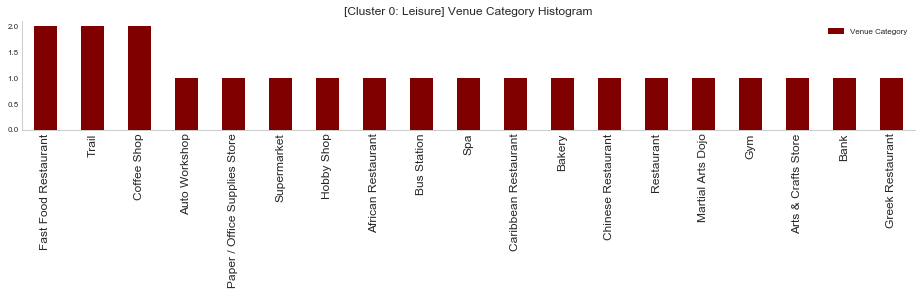

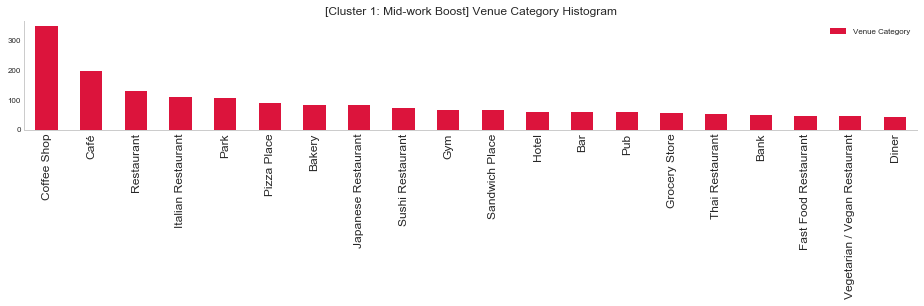

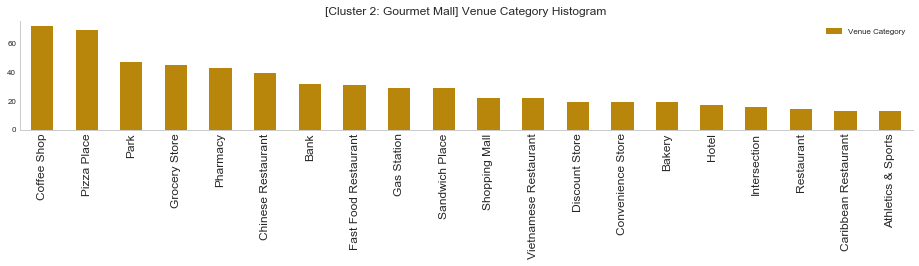

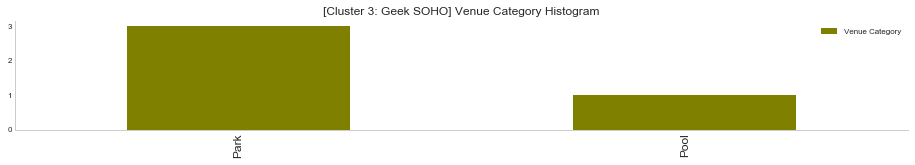

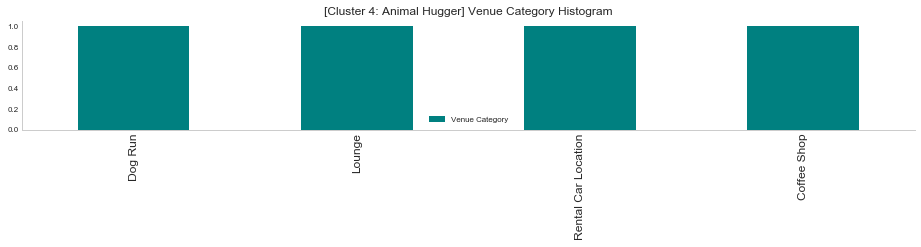

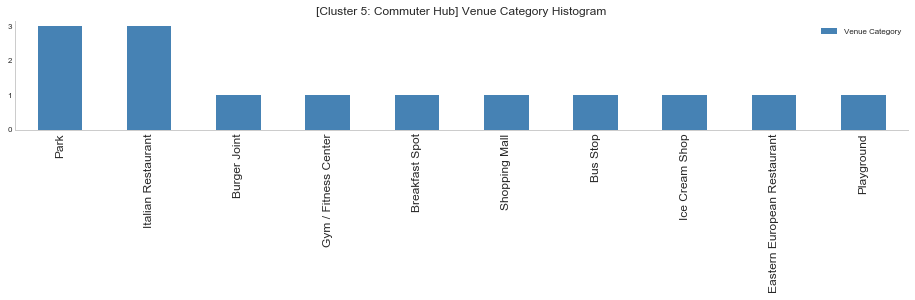

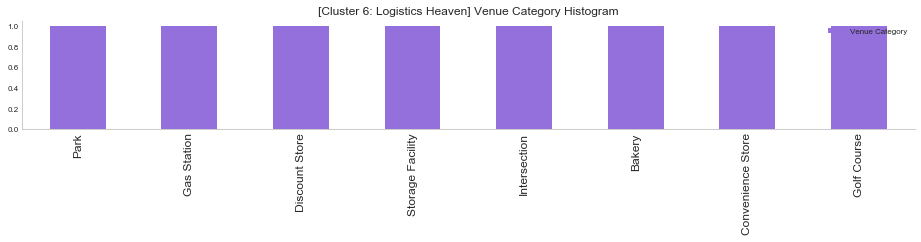

In [18]:
# Histogram of Venue Category count in each Cluster.
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'axes.labelsize': 8, 'legend.fontsize': 8,\
                     'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 8,\
                    'grid.alpha': 0, 'axes.spines.bottom': True, 'axes.spines.left': True,\
                     'axes.spines.right': False, 'axes.spines.top': False})

tvc0c.plot(kind='bar', color='maroon', figsize=(16,2))
plt.title('[Cluster 0: Leisure] Venue Category Histogram')
plt.xticks(rotation=90)
plt.show()
tvc1c.iloc[:20,:].plot(kind='bar', color='crimson', figsize=(16,2))
plt.title('[Cluster 1: Mid-work Boost] Venue Category Histogram')
plt.xticks(rotation=90)
plt.show()
tvc2c.iloc[:20,:].plot(kind='bar', color='darkgoldenrod', figsize=(16,2))
plt.title('[Cluster 2: Gourmet Mall] Venue Category Histogram')
plt.xticks(rotation=90)
plt.show()
tvc3c.plot(kind='bar', color='olive', figsize=(16,2))
plt.title('[Cluster 3: Geek SOHO] Venue Category Histogram')
plt.xticks(rotation=90)
plt.show()
tvc4c.plot(kind='bar', color='teal', figsize=(16,2))
plt.title('[Cluster 4: Animal Hugger] Venue Category Histogram')
plt.xticks(rotation=90)
plt.show()
tvc5c.plot(kind='bar', color='steelblue', figsize=(16,2))
plt.title('[Cluster 5: Commuter Hub] Venue Category Histogram')
plt.xticks(rotation=90)
plt.show()
tvc6c.plot(kind='bar', color='mediumpurple', figsize=(16,2))
plt.title('[Cluster 6: Logistics Heaven] Venue Category Histogram')
plt.xticks(rotation=90)
plt.show()

In [28]:
# Filter out all restaurant from the 'Venue Category' column.
restaur = []
for i in range(len(toron_ven['Venue Category'].unique())):
    if 'Restaurant' in toron_ven['Venue Category'].unique()[i]:
        restaur.append(toron_ven['Venue Category'].unique()[i])
print(restaur)
toron_restaur = toron_ven.copy()
toron_restaur = toron_restaur[toron_restaur['Venue Category'].isin(restaur)]
toron_restaur.to_csv('toron_restaur.csv', index=0)
toron_restaur = pd.read_csv('toron_restaur.csv')
toron_restaur.head()

['Caribbean Restaurant', 'Fast Food Restaurant', 'Chinese Restaurant', 'Portuguese Restaurant', 'French Restaurant', 'Restaurant', 'Mediterranean Restaurant', 'Italian Restaurant', 'Mexican Restaurant', 'Thai Restaurant', 'German Restaurant', 'Middle Eastern Restaurant', 'Sushi Restaurant', 'Indian Restaurant', 'Pakistani Restaurant', 'Vietnamese Restaurant', 'Greek Restaurant', 'Seafood Restaurant', 'Japanese Restaurant', 'Ramen Restaurant', 'Vegetarian / Vegan Restaurant', 'Ethiopian Restaurant', 'Theme Restaurant', 'Modern European Restaurant', 'African Restaurant', 'Asian Restaurant', 'New American Restaurant', 'Dim Sum Restaurant', 'American Restaurant', 'Latin American Restaurant', 'Korean Restaurant', 'Comfort Food Restaurant', 'Falafel Restaurant', 'South American Restaurant', 'Eastern European Restaurant', 'Jewish Restaurant', 'Hakka Restaurant', 'Afghan Restaurant', 'Turkish Restaurant', 'Brazilian Restaurant', 'Doner Restaurant', 'Cuban Restaurant', 'Tapas Restaurant', 'Dump

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0         Parkwoods               43.753259               -79.329656   
1         Parkwoods               43.753259               -79.329656   
2         Parkwoods               43.753259               -79.329656   
3  Victoria Village               43.725882               -79.315572   
4  Victoria Village               43.725882               -79.315572   

                         ID                Venue  Venue Latitude  \
0  4b8991cbf964a520814232e3      Allwyn's Bakery       43.759840   
1  58a8dcaa6119f47b9a94dc05                  A&W       43.760643   
2  4c0150f4716bc9b65b9dbb55  Spicy Chicken House       43.760639   
3  4f3ecce6e4b0587016b6f30d            Portugril       43.725819   
4  4d689350b6f46dcb77ee15b2             The Frig       43.727051   

   Venue Longitude         Venue Category Postal Code     Borough  \
0       -79.324719   Caribbean Restaurant         M3A  North York   
1       -79.326865   Fast Food Restaurant         M3A  North York   
2       -79.325671     Chinese Restaurant         M3A  North York   
3       -79.312785  Portuguese Restaurant         M4A  North York   
4       -79.317418      French Restaurant         M4A  North York   

   Cluster_Labels 1st Most Common Venue 2nd Most Common Venue  \
0               2                  Park     Convenience Store   
1               2                  Park     Convenience Store   
2               2                  Park     Convenience Store   
3               1           Coffee Shop           Men's Store   
4               1           Coffee Shop           Men's Store   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0              Bus Stop               Pharmacy         Shopping Mall   
1              Bus Stop               Pharmacy         Shopping Mall   
2              Bus Stop               Pharmacy         Shopping Mall   
3         Grocery Store  Portuguese Restaurant   Sporting Goods Shop   
4         Grocery Store  Portuguese Restaurant   Sporting Goods Shop   

            Theme  
0    Gourmet Mall  
1    Gourmet Mall  
2    Gourmet Mall  
3  Mid-work Boost  
4  Mid-work Boost

In [29]:
toron_ven_clu0 = pd.DataFrame()
toron_ven_clu1 = pd.DataFrame()
toron_ven_clu2 = pd.DataFrame()
toron_ven_clu3 = pd.DataFrame()
toron_ven_clu4 = pd.DataFrame()
toron_ven_clu5 = pd.DataFrame()
toron_ven_clu6 = pd.DataFrame()
venstr0 = ''
venstr1 = ''
venstr2 = ''
venstr3 = ''
venstr4 = ''
venstr5 = ''
venstr6 = ''
toron_ven_clu0 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 0, toron_restaur.columns[[4]]]
toron_ven_clu1 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 1, toron_restaur.columns[[4]]]
toron_ven_clu2 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 2, toron_restaur.columns[[4]]]
toron_ven_clu3 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 3, toron_restaur.columns[[4]]]
toron_ven_clu4 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 4, toron_restaur.columns[[4]]]
toron_ven_clu5 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 5, toron_restaur.columns[[4]]]
toron_ven_clu6 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 6, toron_restaur.columns[[4]]]
toron_ven_clu_ri0 = toron_ven_clu0.reset_index()
toron_ven_clu_ri1 = toron_ven_clu1.reset_index()
toron_ven_clu_ri2 = toron_ven_clu2.reset_index()
toron_ven_clu_ri3 = toron_ven_clu3.reset_index()
toron_ven_clu_ri4 = toron_ven_clu4.reset_index()
toron_ven_clu_ri5 = toron_ven_clu5.reset_index()
toron_ven_clu_ri6 = toron_ven_clu6.reset_index()
for i in toron_ven_clu_ri0.index:
    venstr0 += toron_ven_clu_ri0.loc[i, 'Venue']
print('Cluster 0 string:\n', venstr0)
for i in toron_ven_clu_ri1.index:
    venstr1 += toron_ven_clu_ri1.loc[i, 'Venue']
print('Cluster 1 string:\n', venstr1)
for i in toron_ven_clu_ri2.index:
    venstr2 += toron_ven_clu_ri2.loc[i, 'Venue']
print('Cluster 2 string:\n', venstr2)
for i in toron_ven_clu_ri3.index:
    venstr3 += toron_ven_clu_ri3.loc[i, 'Venue']
print('Cluster 3 string:\n', venstr3)
for i in toron_ven_clu_ri4.index:
    venstr4 += toron_ven_clu_ri4.loc[i, 'Venue']
print('Cluster 4 string:\n', venstr4)
for i in toron_ven_clu_ri5.index:
    venstr5 += toron_ven_clu_ri5.loc[i, 'Venue']
print('Cluster 5 string:\n', venstr5)
for i in toron_ven_clu_ri6.index:
    venstr6 += toron_ven_clu_ri6.loc[i, 'Venue']
print('Cluster 6 string:\n', venstr6)

Cluster 0 string:
 Harvey'sWendy’sWendy'sCaribbean WaveMr JerkCharley's Exotic CuisineMr. Greek
Cluster 1 string:
 PortugrilThe FrigImpact KitchenSouk TabuleCluny Bistro & BoulangerieMangia and Bevi Resto-BarEl CatrinSukhothaiFusaro'sSchnitzel QueenCluck ClucksPaintbox BistroMystic MuffinQi sushiSukhothaiSushi BarSultan Of SamosasKing's Place647-352-0786Lac Vien Vietnamese RestaurantYuki Japanese RestaurantThe Burger's PriestKrystosHarvey'sTora Aburi SushiRed LobsterBurger KingViet HouseShoeless Joe'sWendy’sMercattoTokyo SushiComo En CasaTokyo GrillSansotei Ramen 三草亭Somethin' 2 Talk AboutVegetarian HavenEthiopian HouseStorm Crow ManorScaddabush Italian Kitchen & BarThe Elm Tree RestaurantKothur Indian CuisineWishSi LomJapangoKinka Izakaya OriginalFabarnakKAKAParamount Fine FoodsTrattoria NervosaRed LobsterWow! SushiRolltationKinton RamenSabai SabaiYamato Japanese RestaurantIsland FoodsIsland FoodsMatsuda Japanese Cuisine & TeppanyakiMatsuda Japanese Cuisine & TeppanyakiGonoe SushiGonoe

Cluster 0: Leisure



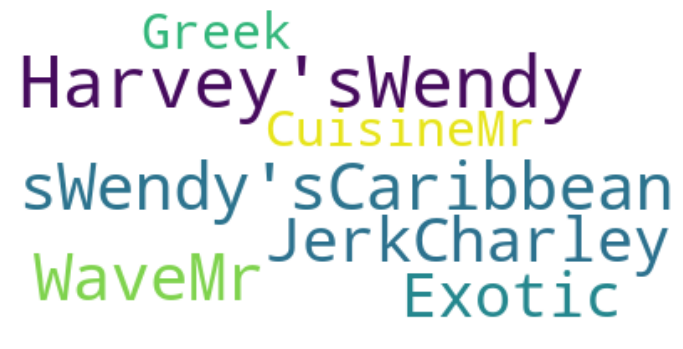

Cluster 1: Mid-work Boost



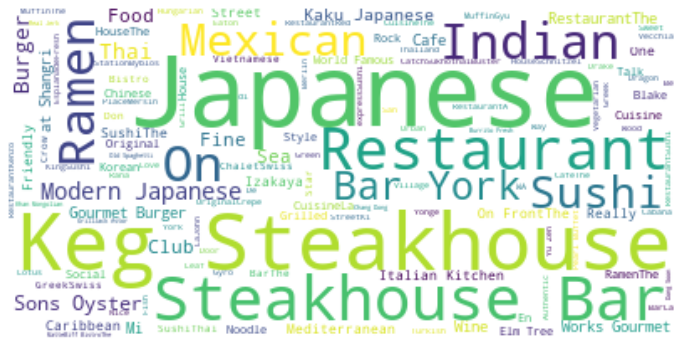

Cluster 2: Gourmet Mall



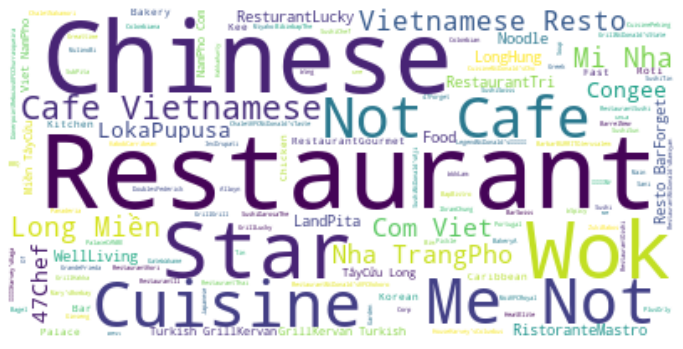

Cluster 5: Commuter Hub



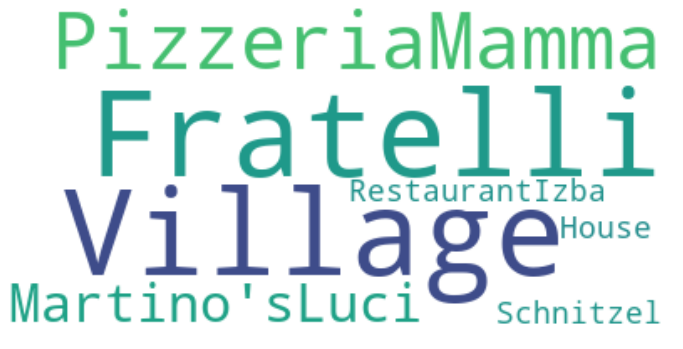

In [30]:
stopwords = set(STOPWORDS)
# instantiate a word cloud object
toron_ven_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
toron_ven_wc.generate(venstr0)
# display the word cloud
print('Cluster 0: Leisure\n')
plt.figure(figsize=(12, 8))
plt.imshow(toron_ven_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# generate the word cloud
toron_ven_wc.generate(venstr1)
# display the word cloud
print('Cluster 1: Mid-work Boost\n')
plt.figure(figsize=(12, 8))
plt.imshow(toron_ven_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# generate the word cloud
toron_ven_wc.generate(venstr2)
# display the word cloud
print('Cluster 2: Gourmet Mall\n')
plt.figure(figsize=(12, 8))
plt.imshow(toron_ven_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Cluster 3, 4 & 6 have ZERO restaurants.

# generate the word cloud
toron_ven_wc.generate(venstr5)
# display the word cloud
print('Cluster 5: Commuter Hub\n')
plt.figure(figsize=(12, 8))
plt.imshow(toron_ven_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

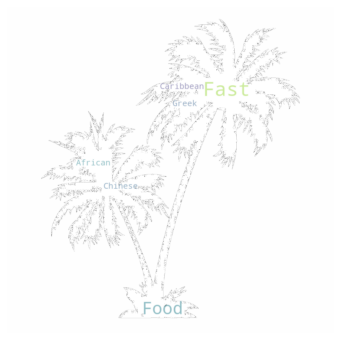

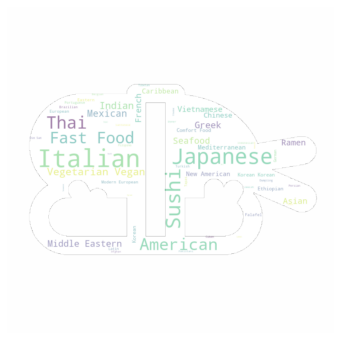

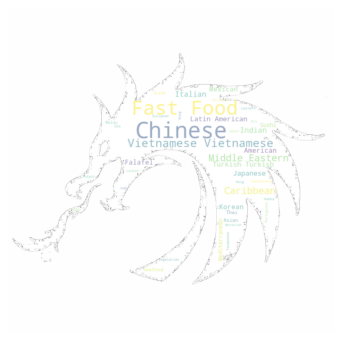

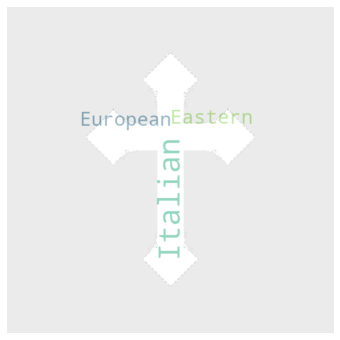

In [34]:
from PIL import Image

# Venue Category Word Cloud.
stopworadrestaur = stopwords.add('Restaurant')

# Create strings for all appeared Venue Categories in Cluster 0, 1, 2 and 5.
toron_ven_cat0 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 0, toron_restaur.columns[[7]]]
toron_ven_cat1 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 1, toron_restaur.columns[[7]]]
toron_ven_cat2 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 2, toron_restaur.columns[[7]]]
toron_ven_cat5 = toron_restaur.loc[toron_restaur['Cluster_Labels'] == 5, toron_restaur.columns[[7]]]
toron_ven_cat_ri0 = toron_ven_cat0.reset_index()
toron_ven_cat_ri1 = toron_ven_cat1.reset_index()
toron_ven_cat_ri2 = toron_ven_cat2.reset_index()
toron_ven_cat_ri5 = toron_ven_cat5.reset_index()
vencatstr0 = ''
vencatstr1 = ''
vencatstr2 = ''
vencatstr5 = ''
for i in toron_ven_cat_ri0.index:
    vencatstr0 += toron_ven_cat_ri0.loc[i, 'Venue Category']
    vencatstr0 += ', '
for i in toron_ven_cat_ri1.index:
    vencatstr1 += toron_ven_cat_ri1.loc[i, 'Venue Category']
    vencatstr1 += ', '
for i in toron_ven_cat_ri2.index:
    vencatstr2 += toron_ven_cat_ri2.loc[i, 'Venue Category']
    vencatstr2 += ', '
for i in toron_ven_cat_ri5.index:
    vencatstr5 += toron_ven_cat_ri5.loc[i, 'Venue Category']
    vencatstr5 += ', '
vencatstr0 = vencatstr0.replace('Restaurant', '')
vencatstr1 = vencatstr1.replace('Restaurant', '')
vencatstr2 = vencatstr2.replace('Restaurant', '')
vencatstr5 = vencatstr5.replace('Restaurant', '')
#print(vencatstr0, vencatstr1, vencatstr2, vencatstr5)

# Load mask images.
cla0 = np.array(Image.open('coconut-tree.jpg'))
cla1 = np.array(Image.open('sushi.jpg'))
cla2 = np.array(Image.open('dragon.jpg'))
cla5 = np.array(Image.open('catholic-cross.jpg'))
cla0png = np.array(Image.open('coconut-tree.png'))
cla1png = np.array(Image.open('sushi.png'))
cla2png = np.array(Image.open('dragon.png'))
cla5png = np.array(Image.open('catholic-cross.png'))

# instantiate a word cloud object
cla0_wc = WordCloud(background_color='white', max_words=2000, mask=cla0, stopwords=stopworadrestaur)
# generate the word cloud
cla0_wc.generate(vencatstr0)
# display the word cloud
fig = plt.figure()
fig.set_figwidth(6) # set width
fig.set_figheight(6) # set height
plt.imshow(cla0_wc, interpolation='bilinear')
plt.imshow(cla0png, interpolation='bilinear', alpha=0.5)
plt.axis('off')
plt.show()

# instantiate a word cloud object
cla1_wc = WordCloud(background_color='white', max_words=2000, mask=cla1, stopwords=stopworadrestaur)
# generate the word cloud
cla1_wc.generate(vencatstr1)
# display the word cloud
fig = plt.figure()
fig.set_figwidth(6) # set width
fig.set_figheight(6) # set height
plt.imshow(cla1_wc, interpolation='bilinear')
plt.imshow(cla1png, interpolation='bilinear', alpha=0.5)
plt.axis('off')
plt.show()

# instantiate a word cloud object
cla2_wc = WordCloud(background_color='white', max_words=2000, mask=cla2, stopwords=stopworadrestaur)
# generate the word cloud
cla2_wc.generate(vencatstr2)
# display the word cloud
fig = plt.figure()
fig.set_figwidth(6) # set width
fig.set_figheight(6) # set height
plt.imshow(cla2_wc, interpolation='bilinear')
plt.imshow(cla2png, interpolation='bilinear', alpha=0.5)
plt.axis('off')
plt.show()

# instantiate a word cloud object
cla5_wc = WordCloud(background_color='white', max_words=2000, mask=cla5, stopwords=stopworadrestaur)
# generate the word cloud
cla5_wc.generate(vencatstr5)
# display the word cloud
fig = plt.figure()
fig.set_figwidth(6) # set width
fig.set_figheight(6) # set height
plt.imshow(cla5_wc, interpolation='bilinear')
plt.imshow(cla5png, interpolation='bilinear', alpha=0.5)
plt.axis('off')
plt.show()

In [49]:
# Testing: Get ratings of the 1st restaurant in list through Foursquares API.
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(toron_restaur.loc[0, 'ID'], CLIENT_ID, CLIENT_SECRET, VERSION)
result = requests.get(url).json()
toron_restaur['Rating'] = toron_restaur.apply(lambda x: result['response']['venue']['rating']\
                                              if 'venue' in result['response'] else \
                                              np.nan, axis=1)
try:
    print(result['response']['venue']['id'], result['response']['venue']['rating'], result['response']['venue']['name'])
except:
    print(result['meta']['errorDetail'])
toron_restaur.head(1)

4b8991cbf964a520814232e3 8.9 Allwyn's Bakery


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0     Parkwoods               43.753259               -79.329656   

                         ID            Venue  Venue Latitude  Venue Longitude  \
0  4b8991cbf964a520814232e3  Allwyn's Bakery        43.75984       -79.324719   

         Venue Category Postal Code     Borough  Cluster_Labels  \
0  Caribbean Restaurant         M3A  North York               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Park     Convenience Store              Bus Stop   

  4th Most Common Venue 5th Most Common Venue         Theme  Rating  
0              Pharmacy         Shopping Mall  Gourmet Mall     8.9

In [173]:
# Morning after 9:00. - testing
toron_restaur['Rating'] = None
for i, v in toron_restaur.loc[:2, 'ID'].iteritems():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(v, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        print(result['response']['venue']['id'], result['response']['venue']['rating'], result['response']['venue']['name'])
        toron_restaur.loc[i, 'Rating'] = result['response']['venue']['rating']
    except:
        print(toron_restaur.loc[i, 'Venue'], 'has not been rated yet.')
toron_restaur.head(3)

4b8991cbf964a520814232e3 8.9 Allwyn's Bakery
58a8dcaa6119f47b9a94dc05 6.8 A&W
Spicy Chicken House has not been rated yet.


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0     Parkwoods               43.753259               -79.329656   
1     Parkwoods               43.753259               -79.329656   
2     Parkwoods               43.753259               -79.329656   

                         ID                Venue  Venue Latitude  \
0  4b8991cbf964a520814232e3      Allwyn's Bakery       43.759840   
1  58a8dcaa6119f47b9a94dc05                  A&W       43.760643   
2  4c0150f4716bc9b65b9dbb55  Spicy Chicken House       43.760639   

   Venue Longitude        Venue Category Postal Code     Borough  \
0       -79.324719  Caribbean Restaurant         M3A  North York   
1       -79.326865  Fast Food Restaurant         M3A  North York   
2       -79.325671    Chinese Restaurant         M3A  North York   

   Cluster_Labels 1st Most Common Venue 2nd Most Common Venue  \
0               2                  Park     Convenience Store   
1               2                  Park     Convenience Store   
2               2                  Park     Convenience Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Bus Stop              Pharmacy         Shopping Mall   
1              Bus Stop              Pharmacy         Shopping Mall   
2              Bus Stop              Pharmacy         Shopping Mall   

          Theme Rating  
0  Gourmet Mall    8.9  
1  Gourmet Mall    6.8  
2  Gourmet Mall   None

In [ ]:
# Morning after 9:00.
toron_restaur['Rating'] = None
for i, v in toron_restaur['ID'].iteritems():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(v, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        print(result['response']['venue']['id'], result['response']['venue']['rating'], result['response']['venue']['name'])
        toron_restaur.loc[i, 'Rating'] = result['response']['venue']['rating']
    except:
        print(toron_restaur.loc[i, 'Venue'], 'has not been rated yet.')
toron_restaur.head()

4b8991cbf964a520814232e3 8.9 Allwyn's Bakery
58a8dcaa6119f47b9a94dc05 6.8 A&W
Spicy Chicken House has not been rated yet.
4f3ecce6e4b0587016b6f30d 6.5 Portugril
The Frig has not been rated yet.
5612b1cc498e3dd742af0dc8 8.6 Impact Kitchen
57e0745a498ea809dbf75f68 9.2 Souk Tabule
53a22c92498ec91fda7ce133 8.4 Cluny Bistro & Boulangerie
4ad776eef964a520e20a21e3 8.4 Mangia and Bevi Resto-Bar
51ddecee498e1ffd34185d2f 8.0 El Catrin
4ada57aff964a520972121e3 8.6 Sukhothai
4cbdc6784495721ea262617a 8.6 Fusaro's
561ffc99498e1468dac63cdd 8.4 Schnitzel Queen
56423155498e78e89181cb44 7.9 Cluck Clucks
505bacb2e4b0474d876eb78c 7.8 Paintbox Bistro
4b72f550f964a5202e922de3 8.8 Mystic Muffin
4ee1490961aff90fe37e76da 7.9 Qi sushi
59cd8a18e179105e08f003c6 7.1 Sukhothai
4adc95f3f964a520912d21e3 7.1 Sushi Bar
52af6dc5498e33995b0bbf03 6.7 Sultan Of Samosas
548bb041498eff940205b644 6.7 King's Place647-352-0786
4ccc5aebee23a14370591ea8 8.0 Lac Vien Vietnamese Restaurant
4b5f1f11f964a52047a729e3 7.9 Yuki Japanese

Peking Garden Restaurant has not been rated yet.
4f5a855be4b0a4baa1ae0063 8.4 Tori's Bakeshop
4e261a1118a81b3b73a9e1e9 7.9 Veloute Bistro
51fd37b5498e5b11f3af7068 7.5 Xola
587bae87286804584acd2a7a 8.0 Isabella’s Boutique Restaurant
4aff4c2df964a520103722e3 7.2 Yumei Sushi
5aa5509cbed48336116ed8a8 7.4 Green Eggplant
4dcd7c6352b1f8915b7e7f7e 6.9 Delhi Bistro
4adb78e8f964a520d82721e3 6.9 Green Basil
4d4d9acf1a2d721e0e31991d 7.3 Cool Runnings
553588fb498ea7ca06504fc8 7.0 The Real Jerk Beaches
5622e665498ecd5d33424dcf 6.7 Kyouka Ramen
4c10317981e976b075d10eeb 6.4 Bikkuri Japanese Restaurant
4c535e4afd2ea593856b4f28 6.3 The Goof
5179b2b4e4b00ac936bb9b1e 6.3 Souvlaki Hut
4ab81980f964a5202f7c20e3 5.7 The Salty Dog
4b56a44ff964a5206e1728e3 8.7 The Keg Steakhouse + Bar - Esplanade
5b5bca904aa3f8002c97f85d 8.9 Fresh On Front
534effeb498e6464d5c4885c 8.5 Market Street Catch
56201ed4498e7f700c462170 9.0 Miku
4b86b209f964a520cf9631e3 8.4 Buster's Sea Cove
50b7c53616485cd9efad60d5 8.1 Sukhothai
5a4fd

4b9fe242f964a520614737e3 7.3 Carribean Heat
4d02ddfbc2e53704abf9ad67 7.4 Elite Restaurant
4b2eb236f964a5202de524e3 6.0 Oishi Sushi
4ae110eef964a520018521e3 5.9 McDonald's
Aji Sushi has not been rated yet.
Tin Tin Congee - 天天粥麵 has not been rated yet.
Mr.Sub has not been rated yet.
Pita Ikram has not been rated yet.
4c8e992db3bcb60c0dd65a27 8.2 Mr. Pide
5155ca12e4b0e05526806bdf 9.0 The Wren
4adcb1a9f964a520d52e21e3 7.9 Danforth Dragon Restaurant
4ad9221cf964a520671821e3 8.9 Rendez-Vous Restaurant Bar & Cafe
4ec8524d6c251306cc822d86 7.5 Ha gow Dim Sum House
502826ffe4b039d48c722f78 8.1 Athens Restaurant & Bar
514237e9e4b0041cb82cdd54 7.9 Al Mandi Restaurant مطعم المندي
58f3a1972b98444cc96f4c53 7.7 Sala Modern Thai Kitchen & Bar
5aeeffcfcf72a0002c937ed8 7.9 City Betty
524b52fd11d27b378fdc5dc6 7.2 Nakayoshi: Ramen Fine Japanese Cuisine
4cb63a749c7ba35dd2469006 7.1 Lalibela
4b13355af964a520879523e3 7.4 Folia Grill
4fd9e460e4b0cbee31aa225b 7.3 Zorba Mezedes
53d2e5e4498e4febaf28f2b8 7.0 Tzatz

Cactus Club Cafe has not been rated yet.
The Keg Steakhouse + Bar - York Street has not been rated yet.
Ki Modern Japanese + Bar has not been rated yet.
Bosk at Shangri-La has not been rated yet.
John & Sons Oyster House has not been rated yet.
Richmond Station has not been rated yet.
Byblos Toronto has not been rated yet.
Pai has not been rated yet.
Rosalinda has not been rated yet.
The Keg Steakhouse + Bar - Esplanade has not been rated yet.
Fresh On Front has not been rated yet.
The Chase has not been rated yet.
TOCA has not been rated yet.
Kellys Landing has not been rated yet.


In [51]:
toron_restaur.tail()

Neighbourhood  \
1262  Mimico NW, The Queensway West, South of Bloor,...   
1263  Mimico NW, The Queensway West, South of Bloor,...   
1264  Mimico NW, The Queensway West, South of Bloor,...   

      Neighbourhood Latitude  Neighbourhood Longitude  \
1262               43.628841               -79.520999   
1263               43.628841               -79.520999   
1264               43.628841               -79.520999   

                            ID                       Venue  Venue Latitude  \
1262  4af764fcf964a520fc0822e3  Kelseys Original Roadhouse       43.622934   
1263  4db0543c0437a93f7f725bd7            Buon Giorno Cafe       43.622801   
1264  4bf1976b99d02d7fa451c948        High Seas Restaurant       43.636058   

      Venue Longitude            Venue Category Postal Code    Borough  \
1262       -79.516427                Restaurant         M8Z  Etobicoke   
1263       -79.519322        Italian Restaurant         M8Z  Etobicoke   
1264       -79.520502  Mediterranean Restaurant         M8Z  Etobicoke   

      Cluster_Labels 1st Most Common Venue 2nd Most Common Venue  \
1262               1            Restaurant  Gym / Fitness Center   
1263               1            Restaurant  Gym / Fitness Center   
1264               1            Restaurant  Gym / Fitness Center   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1262             Pet Store           Yoga Studio         Burrito Place   
1263             Pet Store           Yoga Studio         Burrito Place   
1264             Pet Store           Yoga Studio         Burrito Place   

               Theme  Rating  
1262  Mid-work Boost     6.3  
1263  Mid-work Boost     6.3  
1264  Mid-work Boost     6.3

In [72]:
tr = toron_restaur.drop(toron_restaur.columns[11:17], axis=1)

In [73]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Neighbourhood            1265 non-null   object 
 1   Neighbourhood Latitude   1265 non-null   float64
 2   Neighbourhood Longitude  1265 non-null   float64
 3   ID                       1265 non-null   object 
 4   Venue                    1265 non-null   object 
 5   Venue Latitude           1265 non-null   float64
 6   Venue Longitude          1265 non-null   float64
 7   Venue Category           1265 non-null   object 
 8   Postal Code              1265 non-null   object 
 9   Borough                  1265 non-null   object 
 10  Cluster_Labels           1265 non-null   int64  
 11  Rating                   1265 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 118.7+ KB


In [74]:
tr.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0         Parkwoods               43.753259               -79.329656   
1         Parkwoods               43.753259               -79.329656   
2         Parkwoods               43.753259               -79.329656   
3  Victoria Village               43.725882               -79.315572   
4  Victoria Village               43.725882               -79.315572   

                         ID                Venue  Venue Latitude  \
0  4b8991cbf964a520814232e3      Allwyn's Bakery       43.759840   
1  58a8dcaa6119f47b9a94dc05                  A&W       43.760643   
2  4c0150f4716bc9b65b9dbb55  Spicy Chicken House       43.760639   
3  4f3ecce6e4b0587016b6f30d            Portugril       43.725819   
4  4d689350b6f46dcb77ee15b2             The Frig       43.727051   

   Venue Longitude         Venue Category Postal Code     Borough  \
0       -79.324719   Caribbean Restaurant         M3A  North York   
1       -79.326865   Fast Food Restaurant         M3A  North York   
2       -79.325671     Chinese Restaurant         M3A  North York   
3       -79.312785  Portuguese Restaurant         M4A  North York   
4       -79.317418      French Restaurant         M4A  North York   

   Cluster_Labels  Rating  
0               2     6.3  
1               2     6.3  
2               2     6.3  
3               1     6.3  
4               1     6.3

In [129]:
clulab = [0, 1, 2, 5]
tr0125 = tr.loc[tr['Cluster_Labels'].isin(clulab), tr.columns]
tr0 = tr.loc[tr['Cluster_Labels']==0, tr.columns]
tr1 = tr.loc[tr['Cluster_Labels']==1, tr.columns]
tr2 = tr.loc[tr['Cluster_Labels']==2, tr.columns]
tr5 = tr.loc[tr['Cluster_Labels']==5, tr.columns]
tr0['Cluster_Labels'].value_counts(), tr1['Cluster_Labels'].value_counts(), tr2['Cluster_Labels'].value_counts(), tr5['Cluster_Labels'].value_counts()

(0    7
 Name: Cluster_Labels, dtype: int64,
 1    1033
 Name: Cluster_Labels, dtype: int64,
 2    221
 Name: Cluster_Labels, dtype: int64,
 5    4
 Name: Cluster_Labels, dtype: int64)

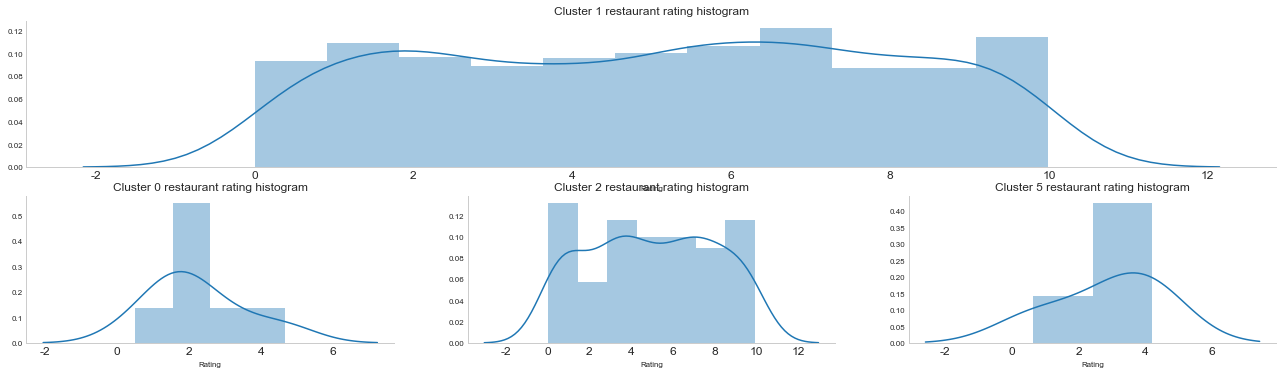

In [130]:
# Histograms of restaurant ratings in Cluster 0, 1, 2 and 5.
import seaborn as sns
plt.figure(figsize=(18,5))
plt.tick_params(labelsize=10)
plt.tight_layout()

plt.subplot(2,1,1)
plt.title("Cluster 1 restaurant rating histogram")
sns.distplot(tr1["Rating"].dropna())
plt.subplot(2,3,4)
plt.title("Cluster 0 restaurant rating histogram")
sns.distplot(tr0["Rating"].dropna())
plt.subplot(2,3,5)
plt.title("Cluster 2 restaurant rating histogram")
sns.distplot(tr2["Rating"].dropna())
plt.subplot(2,3,6)
plt.title("Cluster 5 restaurant rating histogram")
sns.distplot(tr5["Rating"].dropna())

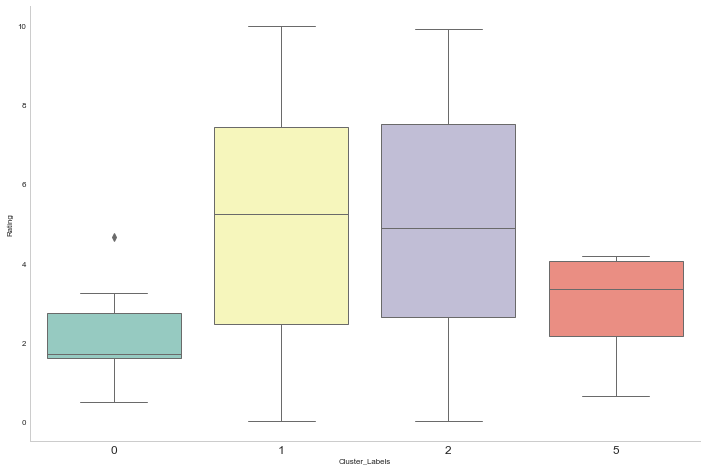

In [163]:
# Boxplot of restaurant ratings in Cluster 0, 1, 2 and 5.
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster_Labels', y='Rating', data=tr0125, palette="Set3", linewidth=1)

<div class='alert alert-info'>
    <h3 align='center'><font face="Trebuchet MS">RESULTS</font></h3><br>
    <hr>
    <font face="Trebuchet MS">
        <h4>Location-based Tactics</h4>
        The output from K-means analysis allows us to define the theme of the 7 clusters. Amongst them, cluster 2 (Gourmet Mall) is densely populated by restaurants, followed by cluster 1 (Mid-work Boost) and cluster 0 (Leisure) where coffee shops and pizza places take a larger chunk of the venue types. Cluster 5 (Commuter Hub) has the least number of restaurants. Cluster 3 (Geek SOHO), 4 (Animal Hugger) and 6 (Logistics Heaven) has no restaurants at all. Restaurants opened in these clusters (0: Leisure, 1: Mid-work Boost and 2: Gourmet Mall) will face brutal competition.
        <br>
        After analyze the name of the restaurants in cluster 0 (Leisure), 1 (Mid-work Boost), 2 (Gourmet Mall) and 5 (Commuter Hub), if we were to open a restaurant in these regions, it will be the best to serve <b><u>Caribbean and Mediterranean</u></b> cuisines in <b>Cluster 0: Gourmet Mall</b>, <b><u>Japanese, Italian and Thai</u></b> cuisines in <b>Cluster 1: Mid-work Boost</b>, <b><u>Chinese and Vietnamese</u></b> cuisines in <b>Cluster 2: Leisure</b>, and possibly <b><u>European</u></b> cuisines in <b>Cluster 5: Commuter Hub</b>(asserted by the name convention in that cluster).
        <br>
        <h4>Restaurant Ratings</h4>
        At the final stage of our data analysis, we used Foursquares API to get the ratings from all listed restaurants in the 4 clusters using venue ID as the search key, and store the returned ratings in the restaurant dataframe we created. The final outputted Histograms reveals that:
        <ul>
            <li><b>Cluster [_]: [_________]</b> has the highest average restaurant rating, while the top rated restaurant is from <b>Cluster [_]: [_________]</b>;</li>
            <li>Restaurant ratings in <b>Cluster 0: Leisure</b> has a <b><u>[_____]</u></b> distribution with the top 10% lies in the range of <b><u>[_____]</u></b> to <b><u>[_____]</u></b>;</li>
            <li>Restaurant ratings in <b>Cluster 1: Mid-work Boost</b> has a <b><u>[_____]</u></b> distribution with the top 10% lies in the range of <b><u>[_____]</u></b> to <b><u>[_____]</u></b>;</li>
            <li>Restaurant ratings in <b>Cluster 2: Gourmet Mall</b> has a <b><u>[_____]</u></b> distribution with the top 10% lies in the range of <b><u>[_____]</u></b> to <b><u>[_____]</u></b>;</li>
            <li>Restaurant ratings in <b>Cluster 5: Commuter Hub</b> has a <b><u>[_____]</u></b> distribution with the top 10% lies in the range of <b><u>[_____]</u></b> to <b><u>[_____]</u></b>;</li>
    </font>
    <hr>
</div>

<div class='alert alert-info'>
    <h3 align='center'><font face="Trebuchet MS">DISCUSSION</font></h3><br>
    <hr>
    <font face="Trebuchet MS">
        <h4>Location Selection</h4>
        By extracting all "Restaurant" tags from Venue Category, we have limited our scope down to venues falling in restaurant category in each clusters. Filtered with the selected tags, it reveals that Cluster 3 (Geek SOHO), 4 (Animal Hugger) and 6 (Logistics Heaven) has ZERO restaurant. Further examination on specific venue category composition of the 3 clusters shows that these neighbourhood are suburban regions with land uses mostly dedicated for public storage, trails, parks, etc. which accommodate very small residential population. A proposed restaurant in these clusters will expect abhorring average count of customers per day and could highly possibly result in a failure in terms of investment. Therefore, suggested locations are within Cluster 0 (Leisure), 1 (Mid-work Boost), 2 (Gourmet Mall) and 5 (Commuter Hub). among which Cluster 1 and 2 has the largest numbers of restaurants with difference in their cuisines. Cluster 0 and 5 are second best choises if taking other factors (utility infrastructures, rent prices, consumption level of the approximate areas, etc.) into consideration.
        <br>
        Speaking of proposed cuisines, Fast Food is the dominion in most (0, 1, 2) clusters and has the largest total number in the entire city. If we are purely seeking revenues, Fast Food restaurant is definitely the best choice of all. If otherwise we are seeking a long term market brand, it's inevitable to consider a cuisine's cultural background.
        <br>
        Caribbean cuisine, Japanese cuisine (especially Sushi), Chinese cuisine and Eastern European cuisin are the first choices for restaurants in Cluster 0, 1, 2 and 5 respectively. For Cluster 0, the second best choice is Mediterranean cuisines. Meanwhile Cluster 1 has the best diversity, with its second and third best choices being Italian and Thai cuisines. At the same time, we should notice that Vegiterian cuisines has a strong presence in this Cluster. Solely from the data at hand we can tell that there's a good chance that Chinatown is located in Cluster 2 neighbourhoods, but Vietnamese cuisines also occupies a considerable chunck of the pie. Cluster 5 has very strong characteristics from the opposite shore of the Atlantic Ocean by naming its restaurant in a European fashion. Last but not the least, for restaurant naming, it's a good tactic to follow the naming conventions of the servicing cuisines' origin country or area.
        <br>
        <h4>Operation Expectation</h4>
        The investors expected all proposed restaurants could rank among top 10% of all restaurants in their clusters respectively within 3 years since opening. In the 4 targeted clusters, the proposed restaurants' ratings have to reach a certain score to meet our expectations. By examining the histograms of restaurant rating distribution in each of the four restaurant-accommodating clusters, we could confidently decide that:
        <ul>
            <li>Restaurant sitting in <b>Cluster 0: Leisure will</b> be expected to achieve a rating higher than <b><u>[_____]</u></b> to rank among the top 10% of all restaurants in this cluster;</li>
            <li>Restaurant sitting in <b>Cluster 1: Mid-work Boost</b> will be expected to achieve a rating higher than <b><u>[_____]</u></b> to rank among the top 10% of all restaurants in this cluster;</li>
            <li>Restaurant sitting in <b>Cluster 2: Gourmet Mall</b> will be expected to achieve a rating higher than <b><u>[_____]</u></b> to rank among the top 10% of all restaurants in this cluster;</li>
            <li>Restaurant sitting in <b>Cluster 5: Commuter Hub</b> will be expected to achieve a rating higher than <b><u>[_____]</u></b> to rank among the top 10% of all restaurants in this cluster;</li>
        </ul>
        The rating data used in this research is acquired from the single source of Foursquares and therefore the data is to some extent biased since Foursquare is a professional geo-information provider rather than a specialized restaurant rating platform. Even among location service providers, such information could vary slightly in different source and statistical scopes (in perspective of customer groups). Not even mention the data from providers such as Yelp of which consumer active rate is much higher, rating participant population is larger, and customer spectrum is more focused, that might be more accurate. But, in the business scenario set for this research, the accuracy is good enough for an early stage targeting on restaurant operation expectation. The diviant contributes little in defecting the findings' business value and therefore can be omitted.
        <br>
        One last thing is that if we observe the acquired rating data closely, there are duplicated venues. This is because the way we getting the venues is by defining the distance radius (1000) from the centroid geographical coordinates of each borough / Postal Code. This methodology forced us to choose between a better coverage (with duplicated venue data) and a less confusing data (with defect on venue sampling in each borough). Surely we can drop the duplicants when scrapping the ratings, but the reason not doing so is because firstly, the duplication amount is small enough to be accepted; secondly, since no borough is shaped in a perfect circle which perfectly fits the venue coverage scope created by our venue searching methodology, if not examine the address of each venue, we cannot completely eliminate the possibility of incorrectly categorizing venue from one borough into another. Not mentioning the total area of the boroughs are not equal and the variance is considerably great, which can be revealed by observing our Folium visualizations and verified by the fact that the closer a borough is to downtown, the more duplicated venues we get. As a conclusion on this topic, it is an error born with the methodology we employed for the reasion of simplicity and therefore cannot be alleviated easily without employing a more sophisticated (to be accurate, coordinate-sensitive) venue searching methodology.
    </font>
    <hr>
</div>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text major ticklabel objects>)

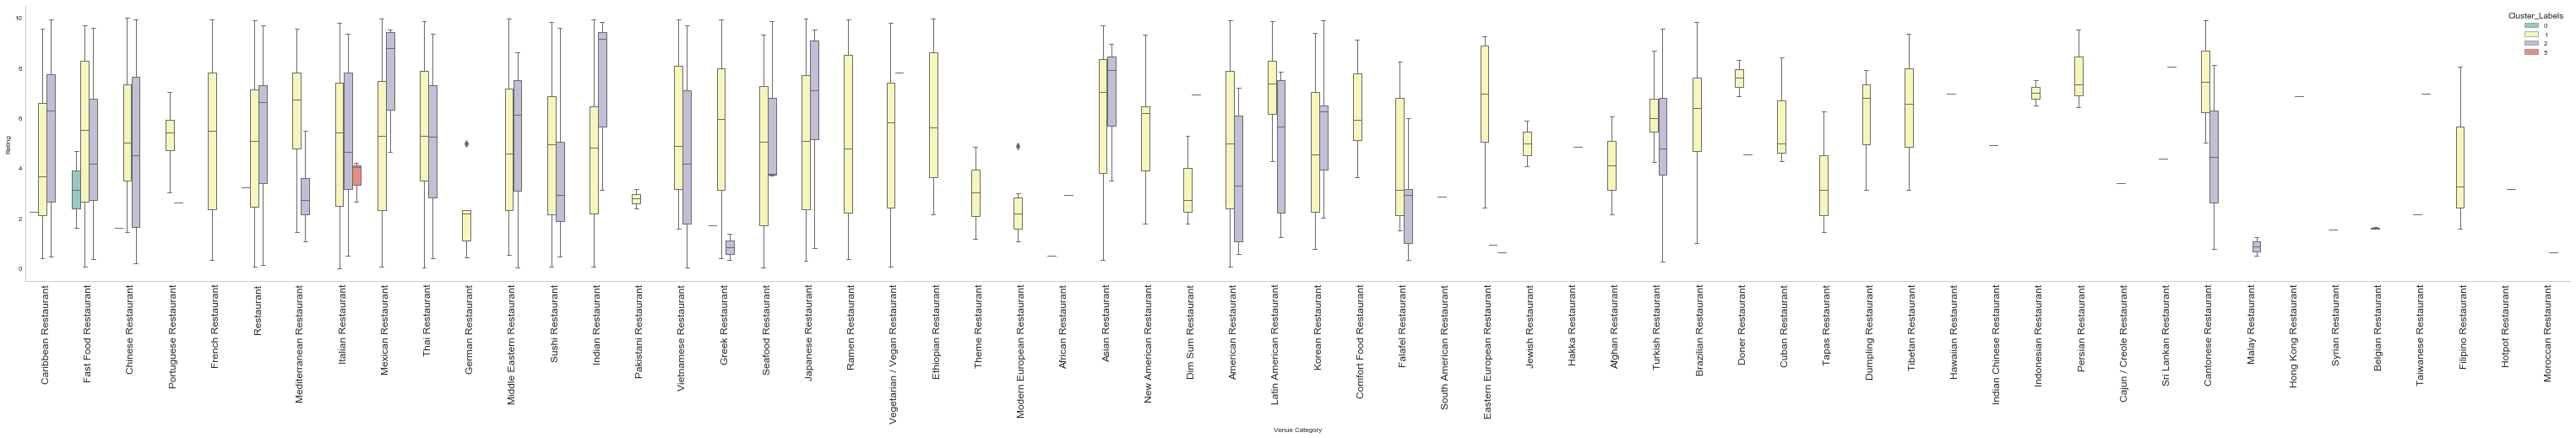

In [158]:
# Boxplot of restaurant ratings in Cluster 0, 1, 2 and 5.
plt.figure(figsize=(54, 6))
sns.boxplot(x='Venue Category', y='Rating', hue='Cluster_Labels', data=tr0125, palette="Set3", linewidth=1)
plt.xticks(rotation=90)

<div class='alert alert-info'>
    <h3 align='center'><font face="Trebuchet MS">CONCLUSION</font></h3><br>
    <hr>
    <font face="Trebuchet MS">
        <h4></h4>
        
        <br>
        
        <br>
        <h4></h4>
        
    </font>
    <hr>
</div>

<div class='alert alert-danger'>
    <h3 align='center'><font face="Trebuchet MS">APPENDIX</font></h3><br>
    <hr>
    <font face="Trebuchet MS">
        Where it got wrong and caused a great pain in my head.
    </font>
    <hr>
</div>

In [50]:
# Get ratings of all existing restaurants in scope through Foursquares API.
'''for i in toron_restaur.loc[1:500, 'ID']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    toron_restaur['Rating'] = toron_restaur.apply(lambda x: result['response']['venue']['rating']\
                                                  if 'rating' in result['response']['venue'] else \
                                                  np.nan, axis=1)
    try:
        print(result['response']['venue']['id'], result['response']['venue']['rating'], result['response']['venue']['name'])
    except:
        print('This venue has not been rated yet.')
toron_restaur.tail(3)'''

58a8dcaa6119f47b9a94dc05 6.8 A&W
This venue has not been rated yet.
4f3ecce6e4b0587016b6f30d 6.5 Portugril
This venue has not been rated yet.
5612b1cc498e3dd742af0dc8 8.6 Impact Kitchen
57e0745a498ea809dbf75f68 9.2 Souk Tabule
53a22c92498ec91fda7ce133 8.4 Cluny Bistro & Boulangerie
4ad776eef964a520e20a21e3 8.4 Mangia and Bevi Resto-Bar
51ddecee498e1ffd34185d2f 8.0 El Catrin
4ada57aff964a520972121e3 8.6 Sukhothai
4cbdc6784495721ea262617a 8.6 Fusaro's
561ffc99498e1468dac63cdd 8.4 Schnitzel Queen
56423155498e78e89181cb44 7.9 Cluck Clucks
505bacb2e4b0474d876eb78c 7.8 Paintbox Bistro
4b72f550f964a5202e922de3 8.8 Mystic Muffin
4ee1490961aff90fe37e76da 7.9 Qi sushi
59cd8a18e179105e08f003c6 7.1 Sukhothai
4adc95f3f964a520912d21e3 7.1 Sushi Bar
52af6dc5498e33995b0bbf03 6.7 Sultan Of Samosas
548bb041498eff940205b644 6.7 King's Place647-352-0786
4ccc5aebee23a14370591ea8 8.0 Lac Vien Vietnamese Restaurant
4b5f1f11f964a52047a729e3 7.9 Yuki Japanese Restaurant
55fc4738498ea821b8d881ae 7.8 The Burger'

51fd37b5498e5b11f3af7068 7.5 Xola
587bae87286804584acd2a7a 8.0 Isabella’s Boutique Restaurant
4aff4c2df964a520103722e3 7.2 Yumei Sushi
5aa5509cbed48336116ed8a8 7.4 Green Eggplant
4dcd7c6352b1f8915b7e7f7e 6.9 Delhi Bistro
4adb78e8f964a520d82721e3 6.9 Green Basil
4d4d9acf1a2d721e0e31991d 7.3 Cool Runnings
553588fb498ea7ca06504fc8 7.0 The Real Jerk Beaches
5622e665498ecd5d33424dcf 6.7 Kyouka Ramen
4c10317981e976b075d10eeb 6.4 Bikkuri Japanese Restaurant
4c535e4afd2ea593856b4f28 6.3 The Goof
5179b2b4e4b00ac936bb9b1e 6.3 Souvlaki Hut
4ab81980f964a5202f7c20e3 5.7 The Salty Dog
4b56a44ff964a5206e1728e3 8.7 The Keg Steakhouse + Bar - Esplanade
5b5bca904aa3f8002c97f85d 8.9 Fresh On Front
534effeb498e6464d5c4885c 8.5 Market Street Catch
56201ed4498e7f700c462170 9.0 Miku
4b86b209f964a520cf9631e3 8.4 Buster's Sea Cove
50b7c53616485cd9efad60d5 8.1 Sukhothai
5a4fdf56772fbc5e9fa73c7f 8.3 Chotto Matte
4b0f3cd2f964a520b66023e3 8.2 Biff's Bistro
50fd7b1b582f9d035e57a426 7.8 The Works Gourmet Burger Bist

This venue has not been rated yet.
4c8e992db3bcb60c0dd65a27 8.2 Mr. Pide
5155ca12e4b0e05526806bdf 9.0 The Wren
4adcb1a9f964a520d52e21e3 7.9 Danforth Dragon Restaurant
4ad9221cf964a520671821e3 8.9 Rendez-Vous Restaurant Bar & Cafe
4ec8524d6c251306cc822d86 7.5 Ha gow Dim Sum House
502826ffe4b039d48c722f78 8.1 Athens Restaurant & Bar
514237e9e4b0041cb82cdd54 7.9 Al Mandi Restaurant مطعم المندي
58f3a1972b98444cc96f4c53 7.7 Sala Modern Thai Kitchen & Bar
5aeeffcfcf72a0002c937ed8 7.9 City Betty
524b52fd11d27b378fdc5dc6 7.2 Nakayoshi: Ramen Fine Japanese Cuisine
4cb63a749c7ba35dd2469006 7.1 Lalibela
4b13355af964a520879523e3 7.4 Folia Grill
4fd9e460e4b0cbee31aa225b 7.3 Zorba Mezedes
53d2e5e4498e4febaf28f2b8 7.0 Tzatziki
4d1267492e583704c5bee3d1 6.9 Akropolis Pastries
4b5a645bf964a52017c228e3 6.9 Wazema Ethiopian Restaurant
5306c4c511d234448cf8010b 7.1 A&W
5d300094521fa500086f821c 6.4 A&W
4d72d530ec075481ab7c8fbf 6.3 Number One Chinese Restaurant
4b0c6669f964a5207e3c23e3 6.0 Makkah Restaurant
4

KeyError: 'venue'